In [86]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm


In [87]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
set_seed(42)
RUNS = 5

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [89]:
data = torch.load("../data/lstm_dataset.pth")

dataset_F = data["dataset_F"].to(device)
dataset_FA = data["dataset_FA"].to(device)
dataset_FAA = data["dataset_FAA"].to(device)
y = data["y"].to(device)
print(dataset_FA.size(), y.size())

K = 10  # Set the number of folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)


torch.Size([162, 5, 11, 33]) torch.Size([162])


In [90]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_len=11, lstm_layers=1, dropout=0):
        super(LSTMClassifier, self).__init__()
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=lstm_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * seq_len, 1)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        batch_size, num_chains, seq_len, feature_dim = x.size()
        x = x.permute(0, 2, 1, 3).reshape(batch_size, seq_len, num_chains * feature_dim)

        # Run through LSTM and collect all time steps
        lstm_out, _ = self.lstm(x)  
        # Combine outputs from all chains
        lstm_out = lstm_out.reshape(batch_size, -1)  # Flatten the outputs
        out = self.fc(lstm_out)
        return out.squeeze()


In [91]:
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(inputs).view(-1)
        loss = criterion(out, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
 

def evaluate(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) 

            outputs = model(inputs).view(-1)
            outputs = torch.sigmoid(outputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def evaluate_with_auc(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).view(-1)
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)

    return fpr, tpr, roc_auc


def get_baseline_acc(loader):
    num_true = 0
    num_samples = 0
    for inputs, labels in loader:
        num_true += int(labels.sum())
        num_samples += labels.size(0)
    return num_true / num_samples

def evaluate_with_fixed_threshold_precision(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).view(-1)
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    precision = precision_score(all_labels, binary_preds, zero_division=0)
    
    return precision

def evaluate_with_fixed_threshold_recall(model, test_loader):
    threshold=0.5
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).view(-1)
            outputs = torch.sigmoid(outputs)
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    binary_preds = [1 if pred >= threshold else 0 for pred in all_preds]
    
    recall = recall_score(all_labels, binary_preds, zero_division = 0)
    
    return recall


### Function Type Only (F)

In [92]:
splits = kf.split(dataset_F)

criterion = nn.BCEWithLogitsLoss()

input_dim = 5 * RUNS # as I am now trying with R=5

lr = 0.001
batch_size = 64
hidden_dim = 32
dropout_p = 0
num_layer = 1
num_epochs = 50


train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 50)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):
    X_train, X_test = dataset_F[train_idx], dataset_F[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  


10it [00:05,  1.68it/s]


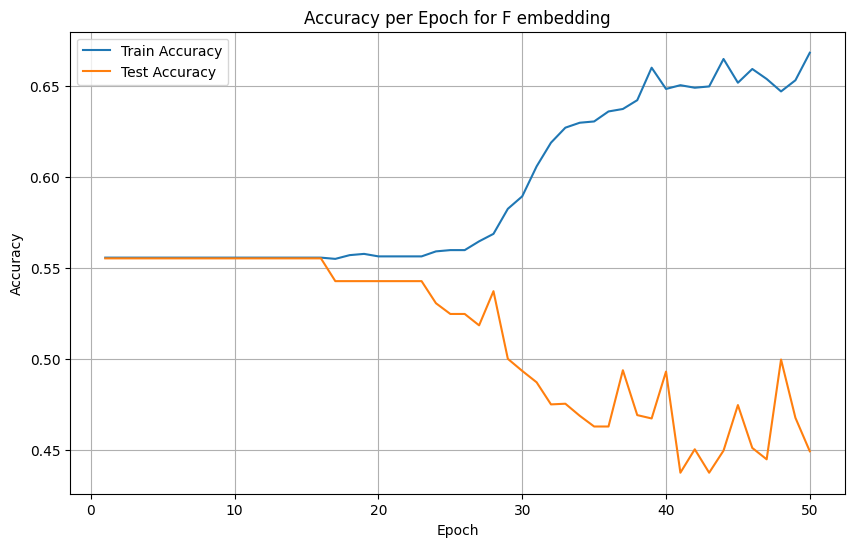

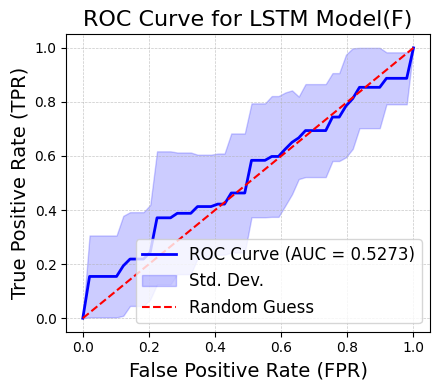

Epoch = 0
Best_mean_accuracy: 0.5551
Best mean_roc_auc: 0.5273
Best mean_precision: 0.0000
Best mean_recall: 0.0000


In [93]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type and Arguments (F+A)

In [94]:
splits = kf.split(dataset_FA)

criterion = nn.BCEWithLogitsLoss()

input_dim = 33 * RUNS

lr = 0.001
batch_size = 16
hidden_dim = 128
dropout_p = 0.5
num_layer = 2
num_epochs = 50

roc_aucs, precisions, recalls = [0] * num_epochs, [0] * num_epochs, [0] * num_epochs
train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):

    X_train, X_test = dataset_FA[train_idx], dataset_FA[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # print(f"X_train shape: {X_train.shape}, y shape: {y.shape}")

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  


10it [00:38,  3.86s/it]


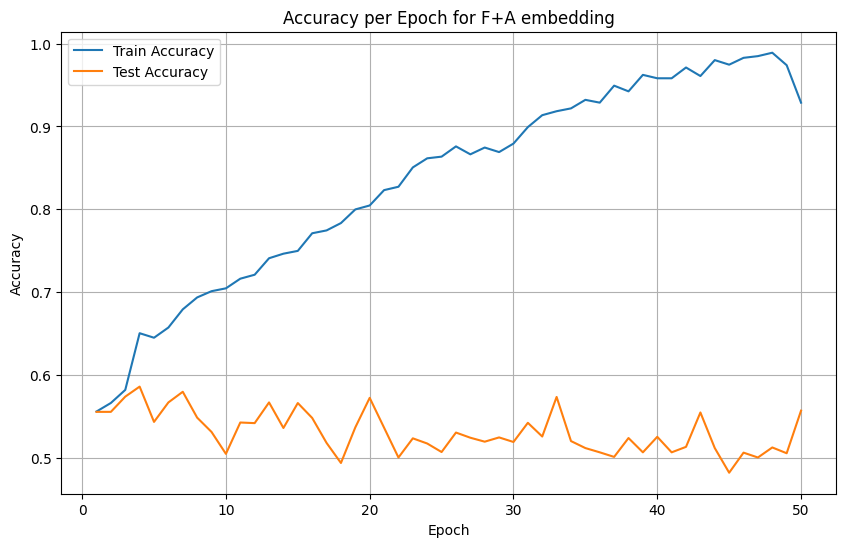

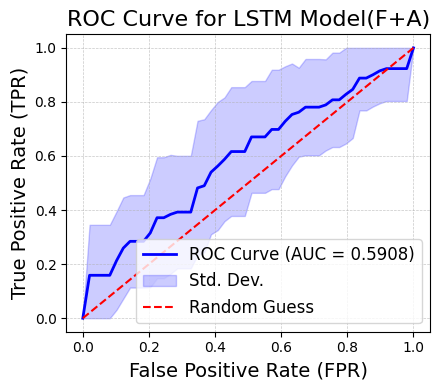

Epoch = 3
Best_mean_accuracy: 0.5857
Best mean_roc_auc: 0.5908
Best mean_precision: 0.5458
Best mean_recall: 0.3315


In [95]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")

### Function Type, Arguments and Answer (F+A+A)

In [96]:
splits = kf.split(dataset_FAA)

criterion = nn.BCEWithLogitsLoss()

input_dim = 33 * RUNS

lr = 0.001
batch_size = 32
hidden_dim = 32
dropout_p = 0
num_layer = 1
num_epochs = 50

train_accs, test_accs = [0] * num_epochs, [0] * num_epochs
precisions, recalls = [0] * num_epochs, [0] * num_epochs

epoch_fprs = [[] for _ in range(num_epochs)]
epoch_tprs = [[] for _ in range(num_epochs)]
mean_fpr = np.linspace(0, 1, 50)

for fold, (train_idx, test_idx) in tqdm(enumerate(splits)):

    X_train, X_test = dataset_FAA[train_idx], dataset_FAA[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # print(f"X_train shape: {X_train.shape}, y shape: {y.shape}")

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)
    
    set_seed(42)
    model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, lstm_layers=num_layer, dropout=dropout_p, seq_len = 12).to(device)

    optimizer = optim.Adam(model.parameters(), lr = lr)


    for epoch in range(num_epochs):
        loss = train(model, train_loader, criterion, optimizer)
        train_acc = evaluate(model, train_loader)
        test_acc = evaluate(model, test_loader)
        fpr, tpr, _ = evaluate_with_auc(model, test_loader)
        precision = evaluate_with_fixed_threshold_precision(model, test_loader)
        recall = evaluate_with_fixed_threshold_recall(model, test_loader)

        train_accs[epoch] += train_acc
        test_accs[epoch] += test_acc
        precisions[epoch] += precision
        recalls[epoch] += recall

        epoch_fprs[epoch].append(fpr)
        epoch_tprs[epoch].append(np.interp(mean_fpr, fpr, tpr))  
        epoch_tprs[epoch][-1][0] = 0.0  

10it [00:09,  1.09it/s]


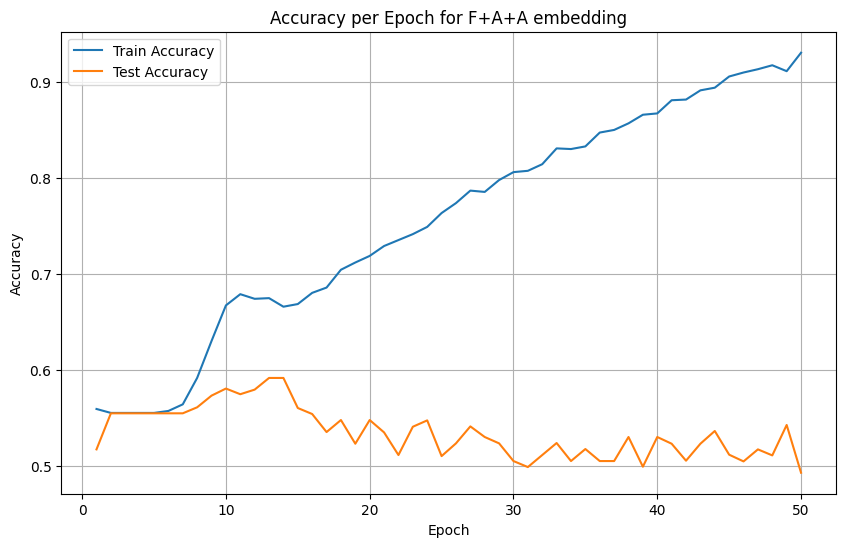

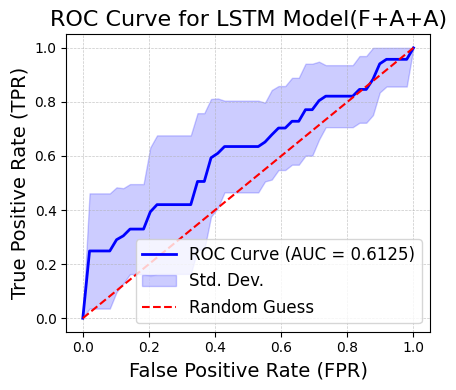

Epoch = 12
Best_mean_accuracy: 0.5919
Best mean_roc_auc: 0.6125
Best mean_precision: 0.6031
Best mean_recall: 0.3947


In [97]:
mean_train_accs = [acc / 10 for acc in train_accs]
mean_test_accs = [acc / 10 for acc in test_accs]
mean_precisions = [pre / 10 for pre in precisions]
mean_recalls = [recall / 10 for recall in recalls]

best_mean_accuracy = max(mean_test_accs)
best_epoch = mean_test_accs.index(best_mean_accuracy)
mean_tpr = np.mean(epoch_tprs[best_epoch], axis=0)
std_tpr = np.std(epoch_tprs[best_epoch], axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plot accuracy graphs over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_train_accs, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), mean_test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Accuracy per Epoch for F+A+A embedding')
plt.legend()
plt.grid(True)
plt.show()

# Plot ROC Curve for the best epoch
plt.figure(figsize=(4.5, 4))
plt.plot(mean_fpr, mean_tpr, label=f'ROC Curve (AUC = {mean_roc_auc:.4f})', color='blue', linewidth=2)
plt.fill_between(mean_fpr, np.maximum(mean_tpr-std_tpr, 0), np.minimum(mean_tpr+std_tpr, 1), color = 'blue', alpha=0.2, label = 'Std. Dev.')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', linewidth=1.5, label='Random Guess')
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title(f'ROC Curve for LSTM Model(F+A+A)', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.savefig("./figures/Figure_lstm_FAA_ROC_AUC.pdf", format="pdf", dpi=300)

plt.show()
    
print(f"Epoch = {best_epoch}")
print(f"Best_mean_accuracy: {mean_test_accs[best_epoch]:.4f}")
print(f"Best mean_roc_auc: {mean_roc_auc:.4f}")
print(f"Best mean_precision: {mean_precisions[best_epoch]:.4f}")
print(f"Best mean_recall: {mean_recalls[best_epoch]:.4f}")